# <center>NLP для iPavlov
## Описание задачи:
- Необходимо создать и протестировать модуль анализа **sentiment** (три класса: **negative**; **neutral**; **positive**) русскоязычного текста, реализованного на статическом датасете.  
- Данные представляют собой несколько датасетов по различным тематикам - *fastfood* (тексты про рестораны быстрого пистания); *prodretail* (тексты про продуктовые магазины); *others* (тексты про все остальное). Есть **train** и **test** сеты по данным 
доменам 
- Основная метрика - F1 для positive и negative классов. 
- Все тексты - комментарии из сети интернет (как обычных пользователей, так и реклама, СМИ и др.)
    
### Имеется **baseline** от компании **iPavlov** по этой задаче, который крайне желательно превзойти:
![](img/baseline.png)

## <center>Предварительные замечания и рассуждения
- Для решения задачи будем использовать предобученную нейронную сеть **BERT** от Гугл. Эта сеть использует двунаправленный многоуровневый механизм внутреннего внимания трансформер-архитектуры.
- на сегодня предобученные сети **BERT** совместно с адаптацией посредством **fine-tunning** показывают чаще всего наилучший результат на задачах NLP. Это связано, в частности, с тем, что благодаря механизму самовнимания удается запомнить для анализа более длинную последовательность чем, например, при использовании сетей архитектуры **RNN** (**LSTM** и **GRU**)
- Мы будем использовать реализацию BERT из библиотеки **transformers**, которая содержит почти все современные архитектуры. 
- решать будем с использованием бесплатной версии **Colab** от Гугл

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# import os
# os.chdir("drive/My Drive/Colab Notebooks/projects/iPavlov")

In [2]:
# !pip install transformers

In [3]:
import os
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig, AutoTokenizer, PreTrainedTokenizer
from transformers import AdamW, BertForSequenceClassification, AutoModel
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
from sklearn.metrics import recall_score, precision_score, f1_score
import matplotlib.pyplot as plt

Если есть GPU, будем использовать ее для обучения. Тем не менее, этот ноутбук можно выполнить и с помощью только CPU. Правда, это будет значительно дольше.

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device == torch.device('cpu'):
    print('Using cpu')
else:
    n_gpu = torch.cuda.device_count()
    print('Using {} GPUs'.format(torch.cuda.get_device_name(0)))

Using GeForce RTX 2080 Ti GPUs


## Загрузка данных


In [5]:
path_to_data = "data"

In [8]:
import pandas as pd


train = pd.read_csv(os.path.join(path_to_data, 'train.csv'), error_bad_lines=False)
test = pd.read_csv(os.path.join(path_to_data, 'test.csv'), error_bad_lines=False)

b'Skipping line 25: expected 2 fields, saw 3\nSkipping line 49: expected 2 fields, saw 3\nSkipping line 60: expected 2 fields, saw 4\nSkipping line 62: expected 2 fields, saw 3\nSkipping line 73: expected 2 fields, saw 3\nSkipping line 93: expected 2 fields, saw 10\nSkipping line 110: expected 2 fields, saw 7\nSkipping line 113: expected 2 fields, saw 5\nSkipping line 131: expected 2 fields, saw 3\nSkipping line 132: expected 2 fields, saw 3\nSkipping line 143: expected 2 fields, saw 8\nSkipping line 174: expected 2 fields, saw 3\nSkipping line 175: expected 2 fields, saw 6\nSkipping line 186: expected 2 fields, saw 3\nSkipping line 190: expected 2 fields, saw 3\nSkipping line 261: expected 2 fields, saw 3\nSkipping line 271: expected 2 fields, saw 3\nSkipping line 273: expected 2 fields, saw 4\nSkipping line 300: expected 2 fields, saw 3\nSkipping line 308: expected 2 fields, saw 3\nSkipping line 332: expected 2 fields, saw 3\nSkipping line 362: expected 2 fields, saw 3\nSkipping line

(часть данных "битые", мы их просто игнорировали при загрузке)

In [9]:
train.shape

(21955, 2)

In [10]:
train.sample(5)

,text,label
11731,ENT около больницы Шпикачки Московские упаковк...,-1
851,Активисты партпроекта « Народный контроль » пр...,-1
20069,Попала в эту акцию в ноябре если кто не успел ...,1
5213,В ENT икра в банках была заметно дешевле чем в...,1
10207,Мы провели рейд в п. Ачит ENT Советская 1А тож...,-1


In [11]:
test.shape

(9386, 2)

In [12]:
test.sample(5)

,text,label
6850,В меге хорошая химчистка возле ENT,0
8638,ENT хороший магазин,1
9142,Мне кажется люди сами плошают лишь бы был пово...,-1
8606,У нас будет новый ENT,0
3372,ENT сеть продуктовых супермаркетов отзывы Хоро...,1


### Подготовим данные для применения в модели

BERT'у нужно предоставить специальный формат входных данных.


- **input ids**: последовательность чисел, отождествляющих каждый токен с его номером в словаре.
- **labels**: вектор из 0, ..., num_labels-1. В нашем случае num_labels = 3.
- **segment mask**: (необязательно) последовательность нулей и единиц, которая показывает, состоит ли входной текст из одного или двух предложений. Для случая одного предложения получится вектор из одних нулей. Для двух: <length_of_sent_1> нулей и <length_of_sent_2> единиц.
- **attention mask**: (необязательно) последовательность нулей и единиц, где единицы обозначают токены предложения, нули - паддинг.

Подготовим списки текстов и меток. Метки скорректируем, как было указано выше (просто приплюсовав 1)

In [13]:
sentences = list(train["text"])
labels = list(train["label"].values + 1)

Подготовим тексты. 

Для этого импортируем токенизатор для BERT'а, который превратит наши тексты в набор токенов, соответствующих тем, что встречаются в словаре предобученной модели. После этого токены перекодируем в их **id**.

Кроме того, отформатируем данные так, чтобы они представляли последовательности одинаковой длинны. Для этого используем паддинг и обрезание текстов.   

Паддинг нужен для того, чтобы BERT мог работать с предложениями разной длины. Выбираем максимально возможную длину предложения (в нашем случае пусть это будет длина 256). Вообще то BERT может работать с последовательностями до 512 символов (что, кстати, почти не доступно для LSTM), но с нашей конфигурацией сервера не хватает памяти для такой последовательности (проверено несколько вариантов длины), поэтому только 256.

Теперь более длинные предложения будем обрезать до 256 токенов, а для более коротких использовать паддинг.  

Подготовку текстов **по формату BERT** может сделать соответствующий **tokenizer** из библиотеки **transformers**, который мы загрузили ранее

In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)

In [15]:
encoded_inputs = tokenizer(sentences, max_length=256, padding=True, truncation=True, return_tensors="pt")

In [16]:
input_ids = encoded_inputs['input_ids']
attention_masks = encoded_inputs['attention_mask']

Метки переведем в тензоры и скорректируем размерности

In [17]:
train_gt = torch.tensor(labels).unsqueeze(1)

## Inputs

Делим данные на `train` и `val`:

In [18]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_gt, 
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)

Обратим внимание, что все наши данные уже представлены в формате `pytorch` тензоров

Воспользуемся классом `DataLoader`. Это поможет нам использовать эффективнее память во время тренировки модели, так как нам не нужно будет загружать в память весь датасет. Данные по батчам будем разбивать произвольно с помощью RandomSampler. Также обратим внимание на размер батча: если во время тренировки возникнет `Memory Error`, размер батча необходимо уменьшить.

In [31]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=16
)

In [32]:
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=16
)

## Обучение модели

Теперь когда данные подготовлены, надо написать пайплайн обучения модели.

Необходимо изменить предобученный BERT так, чтобы он выдавал метки для классификации текстов, а затем файнтюнить его на наших данных. Мы возьмем **готовую модификацию** BERTа для классификации из **transformers**. Она интуитивно понятно называется `BertForSequenceClassification`. Это обычный BERT с уже добавленным линейным слоем для классификации.

Прокомментируем процесс файн-тюнинга.   
Первый токен в каждом предложении - это `[CLS]`. В отличие от скрытого состояния, относящего к обычному слову (не метке `[CLS]`), скрытое состояние относящееся к этой метке должно содержать в себе аггрегированное представление всего предложения, которое дальше будет использоваться для классификации. Таким образом, когда мы скормили предложение в процессе обучения сети, выходом будет вектор со скрытым состоянием, относящийся к метке `[CLS]`. Дополнительный полносвязный слой, который мы добавили, имеет размер `[hidden_state, количество_классов]`, в нашем случае количество классов равно двум. То есть на выходе мы получим **три числа**, представляющих классы "положительная эмоциональная окраска", "нейтральная эмоциональная окраска" и "отрицательная эмоциональная окраска".

Процесс дообучения достаточно дешев. По факту мы тренируем наш верхний слой и немного меняем веса во всех остальных слоях в процессе, чтобы подстроиться под нашу задачу.

Иногда некоторые слои специально "замораживают" или применяют разные стратегии работы с learning rate, в общем, делают все, чтобы сохранить "хорошие" веса в нижних слоях и ускорить дообучение. В целом, замораживание слоев BERTа обычно не сильно сказывается на итоговом качестве, однако надо помнить о тех случаях, когда данные, использованные для предобучения и дообучения очень разные (разные домены или стиль: академическая и разговорная лексика). В таких случаях лучше тренировать все слои сети, не замораживая ничего.

Загружаем BERT. `bert-base-multilingual-cased` - это мультиязычная версия "base", рассчитанная на 104 языка. Выбираем ее, потому что наш датасет на **русском языке**

In [21]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=3)
model.to(device)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

Теперь обсудим гиперпараметры для обучения нашей модели. Обычно советуют выбирать `learning rate` `5e-5`, `3e-5`, `2e-5`, а количество эпох не делать слишком большим, 2-4 вполне достаточно. 

In [33]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)



Сделаем функцию для получения меток предсказания по готовой модели. Это нужно будет для валидации в процессе обучения и для проверки модели на отложенной выборке

In [23]:
def get_preds_labels(model, dataloader):
    """
    Predict by use dataloader

    Return:
    predicted labels and their corresponding true labels
    """
    model.eval()
    preds, labels = [], []

    for batch in dataloader:
        # добавляем батч для вычисления на GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Распаковываем данные из dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # При использовании .no_grad() модель не будет считать и хранить градиенты.
        # Это ускорит процесс предсказания меток для тестовых данных.
        with torch.no_grad():
            logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        # Перемещаем logits и метки классов на CPU для дальнейшей работы
        logits = logits[0].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Сохраняем предсказанные классы и ground truth
        batch_preds = np.argmax(logits, axis=1)
        batch_labels = np.concatenate(label_ids)  
        preds.extend(batch_preds)
        labels.extend(batch_labels)

        return preds, labels

Epoch - 5 / 5


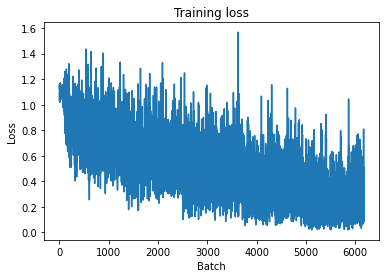

Epoch: 100%|██████████| 5/5 [42:35<00:00, 511.04s/it]

CPU times: user 42min 11s, sys: 28.9 s, total: 42min 40s
Wall time: 42min 35s


In [34]:
%%time

from IPython.display import clear_output

# Будем сохранять train loss и valid scores во время обучения
# и рисовать график в режиме реального времени
train_loss_set = []
epoch_train_loss_log = []
valid_scores = []

# Обучение

# Number of training epochs (recommend between 2 and 4)
epochs = 5

# trange is a tqdm wrapper around the normal python range
for epoch in trange(epochs, desc="Epoch"):
    train_loss = 0
    # Переводим модель в training mode
    model.train()

    for step, batch in enumerate(train_dataloader):
        # добавляем батч для вычисления на GPU
        batch = tuple(t.to(device) for t in batch)
        # Распаковываем данные из dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # если не сделать .zero_grad(), градиенты будут накапливаться
        optimizer.zero_grad()
        
        # Forward pass
        loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        train_loss_set.append(loss[0].item())  
        
        # Backward pass
        loss[0].backward()
        
        # Обновляем параметры и делаем шаг используя посчитанные градиенты
        optimizer.step()

        # Обновляем loss
        train_loss += loss[0].item()
        
        # Рисуем график
        clear_output(True)
        print(f"Epoch - {epoch+1} / {epochs}")
        plt.plot(train_loss_set)
        plt.title("Training loss")
        plt.xlabel("Batch")
        plt.ylabel("Loss")
        plt.show()
        
    epoch_train_loss_log.append(train_loss / len(train_dataloader))
    # print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))


    # Валидация
    valid_preds, valid_labels = get_preds_labels(model, validation_dataloader)

    valid_scores.append(
        {
            "recall": recall_score(valid_labels, valid_preds, average=None), 
            "precision": precision_score(valid_labels, valid_preds, average=None), 
            "f1": f1_score(valid_labels, valid_preds, average=None)
        }
    )

#### Графики **valid scores**

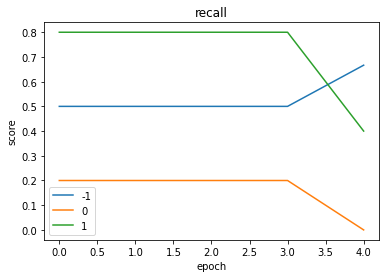

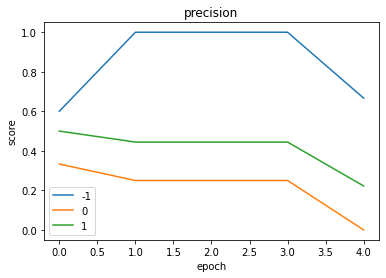

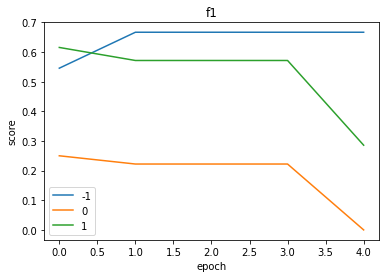

In [35]:
for score in valid_scores[0]:
    for item in range(len(valid_scores[0][score])):
        plt.plot(list(map(lambda x: x[score][item], valid_scores)), label=str(item-1))
        plt.title(score)
        plt.xlabel("epoch")
        plt.ylabel("score")
    plt.legend()
    plt.show()

Метрики на последней эпохе

In [36]:
valid_scores[-1]

{'recall': array([0.66666667, 0.        , 0.4       ]),
 'precision': array([0.66666667, 0.        , 0.22222222]),
 'f1': array([0.66666667, 0.        , 0.28571429])}

## Сохранение тренированной модели (и токенизатора)

Сохранять модель будем сюда

In [37]:
path_to_model = "bert_model_multi_huggpre_upper"

In [38]:
model.save_pretrained(path_to_model)
tokenizer.save_pretrained(path_to_model)

('bert_model_multi_huggpre_upper/vocab.txt',
 'bert_model_multi_huggpre_upper/special_tokens_map.json',
 'bert_model_multi_huggpre_upper/added_tokens.json')

# Оценка качества на отложенной выборке

Делаем точно такую же предобработку для тестовых данных, как и в начале ноутбука делали для обучающих данных:

In [39]:
sentences = list(test["text"])
labels = list(test["label"].values + 1)

# tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
encoded_inputs = tokenizer(sentences, max_length=256, padding=True, truncation=True, return_tensors="pt")

input_ids = encoded_inputs['input_ids']
attention_masks = encoded_inputs['attention_mask']

test_gt = torch.tensor(labels).unsqueeze(1)

In [74]:
prediction_data = TensorDataset(
    input_ids,
    attention_masks,
    test_gt
)

prediction_dataloader = DataLoader(
    prediction_data, 
    sampler=SequentialSampler(prediction_data),
    batch_size=32
)

In [75]:
test_labels, test_preds = get_preds_labels(model, prediction_dataloader)

In [76]:
test_scores = {
            "recall": recall_score(test_labels, test_preds, average=None), 
            "precision": precision_score(test_labels, test_preds, average=None), 
            "f1": f1_score(test_labels, test_preds, average=None)
        }
test_scores

{'recall': array([0.91666667, 1.        , 0.85714286]),
 'precision': array([0.91666667, 0.75      , 1.        ]),
 'f1': array([0.91666667, 0.85714286, 0.92307692])}

### Загрузим модель и проверим работу загруженной модели

In [77]:
%%time
model_loaded = BertForSequenceClassification.from_pretrained(path_to_model).to(device)

CPU times: user 4.32 s, sys: 316 ms, total: 4.64 s
Wall time: 4.31 s


In [78]:
test_labels, test_preds = get_preds_labels(model_loaded, prediction_dataloader)

In [79]:
test_scores = {
            "recall": recall_score(test_labels, test_preds, average=None), 
            "precision": precision_score(test_labels, test_preds, average=None), 
            "f1": f1_score(test_labels, test_preds, average=None), 
            "f1_micro": np.array([f1_score(test_labels, test_preds, average='micro')])
        }
test_scores

{'recall': array([0.91666667, 1.        , 0.85714286]),
 'precision': array([0.91666667, 0.75      , 1.        ]),
 'f1': array([0.91666667, 0.85714286, 0.92307692]),
 'f1_micro': array([0.90625])}

Приведем результат к виду, который попросили в ТЗ, и сохраним в xls файле

In [80]:
result = {}
num_dec = {0: "neg", 1: "neut", 2: "pos"}
score_dec = {"precision": "pre", "recall": "rec", "f1": "f1", "f1_micro": "Av_F1"}
for score in test_scores:
    for num in range(len(test_scores[score])):
        if score != "f1_micro":
            result[f"{num_dec[num]}_{score_dec[score]}"] = [test_scores[score][num]]
        else:
            result[f"{score_dec[score]}"] = [test_scores[score][num]]

In [81]:
cols = ["neg_pre", "neg_rec", "neg_f1", "neut_pre", "neut_rec", "neut_f1", "pos_pre", "pos_rec", "pos_f1", "Av_F1"]
df = pd.DataFrame(result, columns=cols, index=["DSh, Exp."])
df.index.names = ['Creator']

df["Av_tot"] = df.drop("Av_F1", axis=1).mean(axis=1)

df

,neg_pre,neg_rec,neg_f1,neut_pre,neut_rec,neut_f1,pos_pre,pos_rec,pos_f1,Av_F1,Av_tot
Creator,,,,,,,,,,,
"DSh, Exp.",0.916667,0.916667,0.916667,0.75,1.0,0.857143,1.0,0.857143,0.923077,0.90625,0.904151


In [85]:
df.to_excel("dsh_scores_multi_huggpre_upper.xls")